In [36]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import glob
import seaborn as sns
import tensorflow as tf
from  tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Resizing
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Flatten, RandomRotation, RandomTranslation, RandomFlip, RandomContrast
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import cohen_kappa_score
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
base_path = './'

train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))

In [4]:
train_df

,image,label
0,Bishop_0.JPG,Bishop
1,Bishop_1.jpg,Bishop
2,Bishop_10.jpg,Bishop
3,Bishop_11.jpg,Bishop
4,Bishop_12.jpg,Bishop
...,...,...
491,Rook_88.jpg,Rook
492,Rook_89.jpg,Rook
493,Rook_9.jpg,Rook
494,Rook_90.jpg,Rook


In [5]:
train_df.label.value_counts()

Pawn      97
Knight    96
Rook      92
Bishop    77
Queen     68
King      66
Name: label, dtype: int64

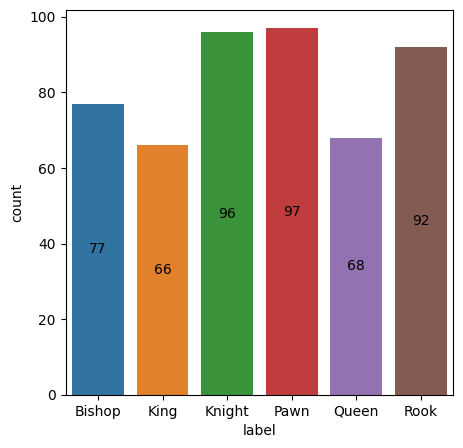

In [6]:
# 데이터 분포

figure = plt.figure(figsize=(5, 5))
ax = figure.add_subplot()
sns.countplot(data=train_df, x='label', ax=ax)

for patch in ax.patches:
    label_x = patch.get_x() + patch.get_width()/2
    label_y = patch.get_y() + patch.get_height()/2
    text_msg = str(int(patch.get_height())) 
    ax.text(label_x, label_y, text_msg, horizontalalignment='center', verticalalignment='center')
    
plt.show()

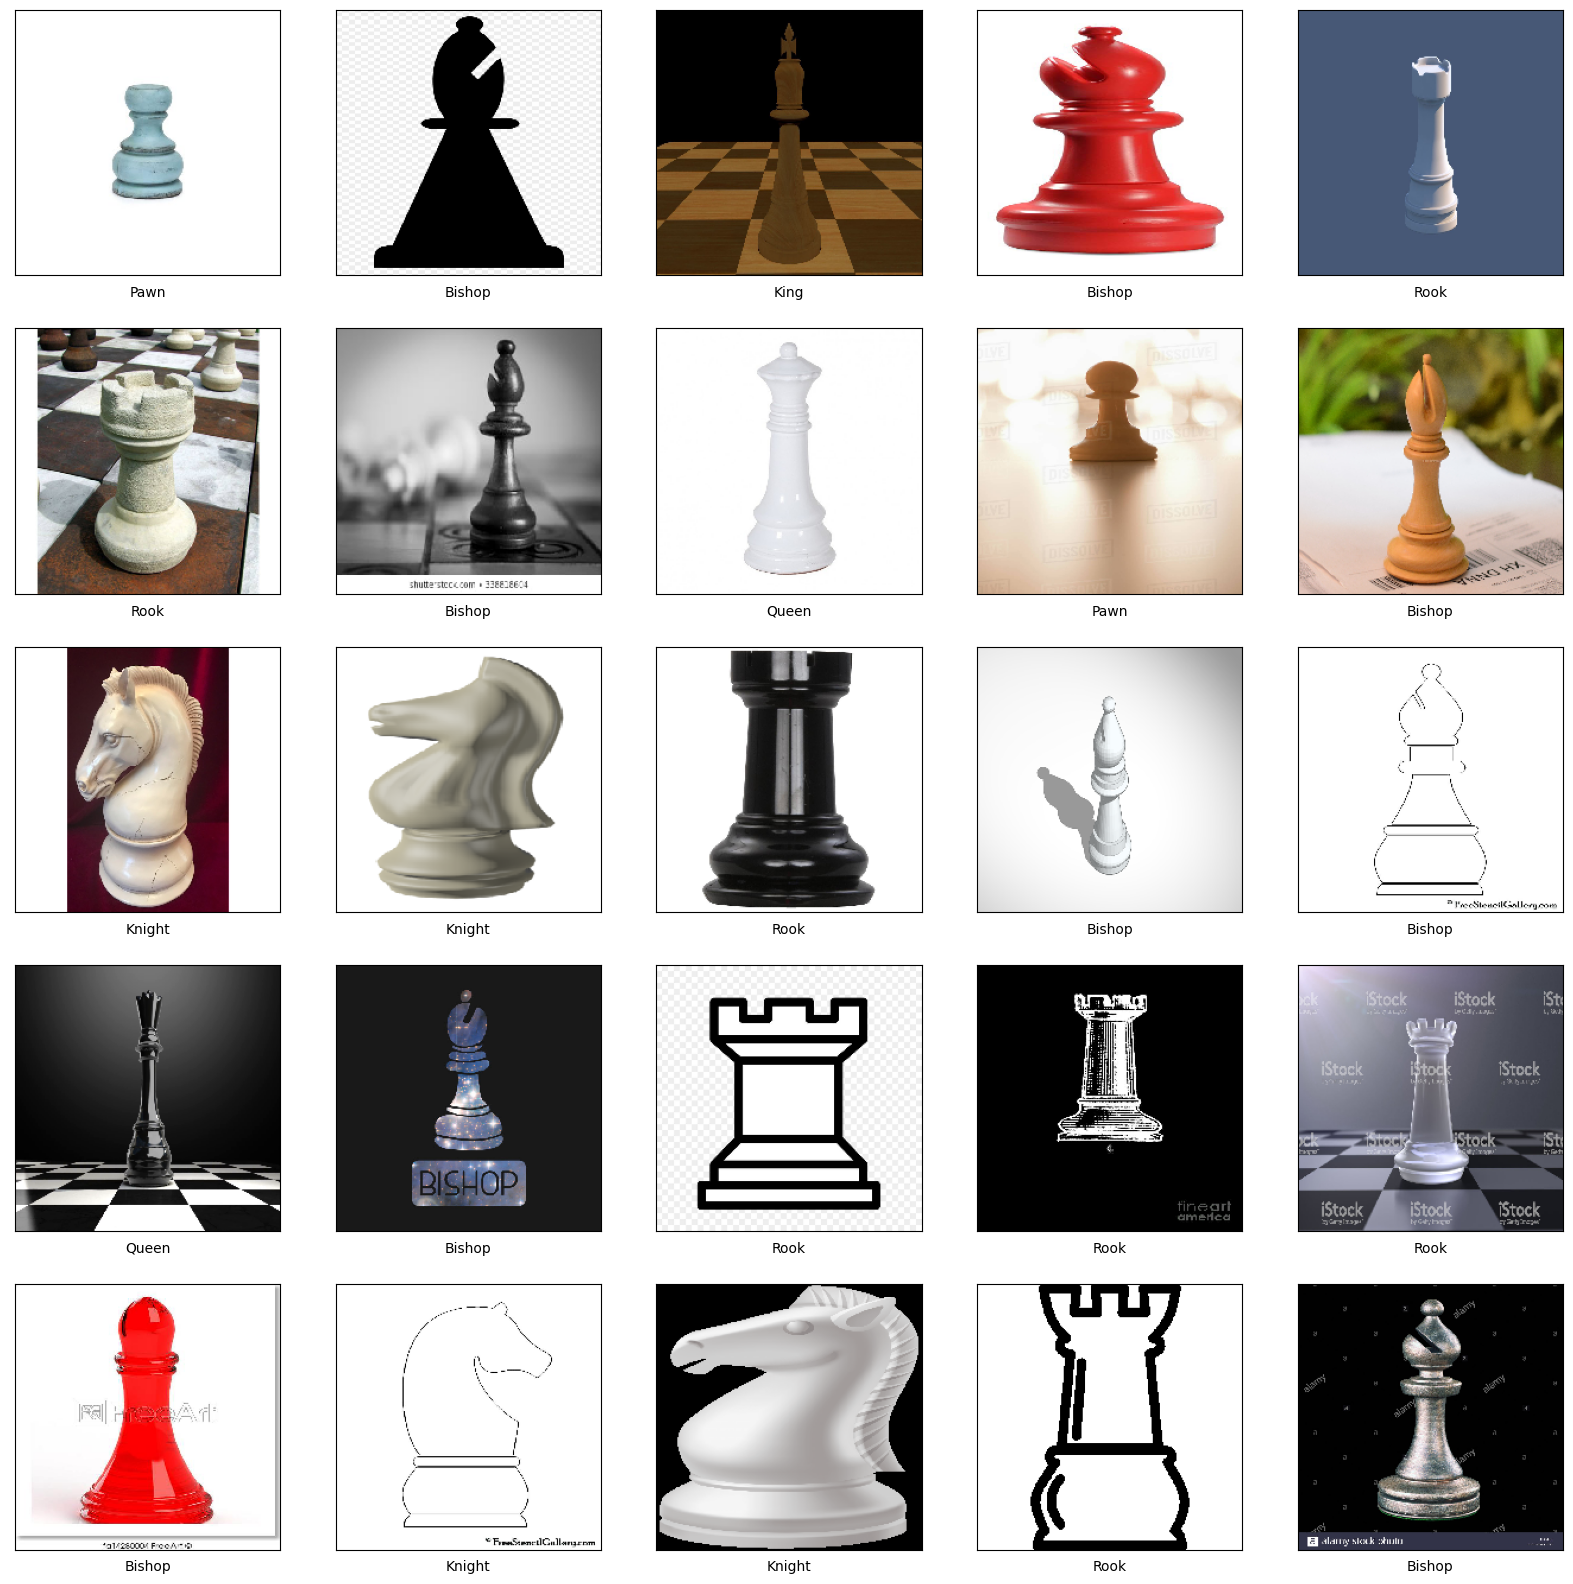

In [7]:
# 이미지 시각화
train_path = base_path +'/train'

plt.figure(figsize=(20,20))
index = np.random.randint(len(train_df), size=25)
for i in range(25):
    label = train_df['label'][index[i]]
    path_img = train_df['image'][index[i]]
    path_img = os.path.join(train_path, os.path.join(label, path_img))
    
    img = image.load_img(path_img,target_size=(224,224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_df, test_size=0.25, stratify=train_df['label'])
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [9]:
train

,image,label
0,Bishop_58.jpg,Bishop
1,Pawn_85.jpg,Pawn
2,Bishop_12.jpg,Bishop
3,Rook_56.png,Rook
4,Knight_69.jpg,Knight
...,...,...
367,Knight_16.jpg,Knight
368,Queen_25.jpg,Queen
369,Knight_57.jpg,Knight
370,King_48.jpg,King


In [10]:
train['image'] = train['image'].map(lambda x: x.split('_')[0]+'/'+x)
train.head(10)

,image,label
0,Bishop/Bishop_58.jpg,Bishop
1,Pawn/Pawn_85.jpg,Pawn
2,Bishop/Bishop_12.jpg,Bishop
3,Rook/Rook_56.png,Rook
4,Knight/Knight_69.jpg,Knight
5,Bishop/Bishop_69.png,Bishop
6,Rook/Rook_73.jpg,Rook
7,King/King_1.jpg,King
8,Bishop/Bishop_76.jpg,Bishop
9,Rook/Rook_6.jpg,Rook


In [11]:
valid['image'] = valid['image'].map(lambda x: x.split('_')[0]+'/'+x)
valid.head(10)

,image,label
0,Rook/Rook_29.jpg,Rook
1,Bishop/Bishop_66.jpg,Bishop
2,Bishop/Bishop_11.jpg,Bishop
3,Queen/Queen_29.jpg,Queen
4,King/King_28.png,King
5,Bishop/Bishop_27.jpg,Bishop
6,Queen/Queen_57.png,Queen
7,Pawn/Pawn_65.jpg,Pawn
8,Pawn/Pawn_13.jpg,Pawn
9,Rook/Rook_90.jpg,Rook


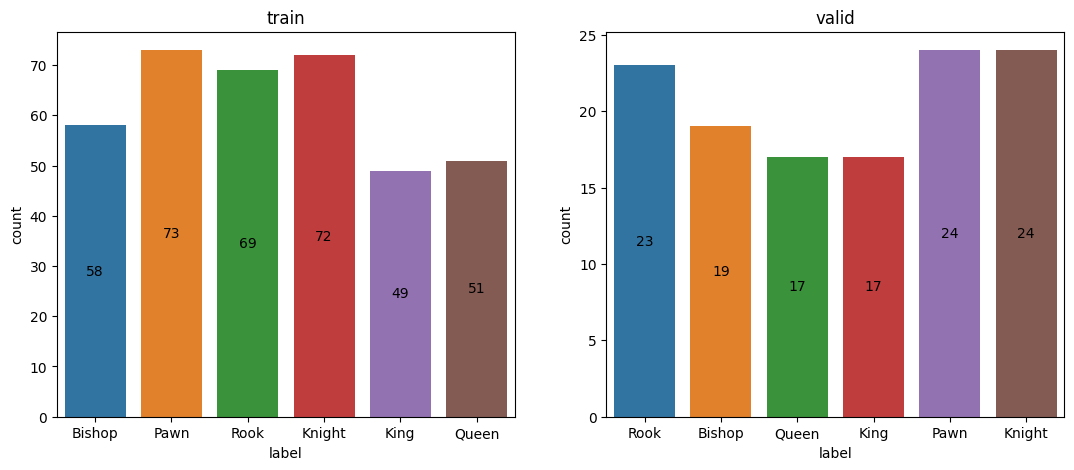

In [12]:
# 분할 후 데이터 분포

figure, ax = plt.subplots(1, 2, figsize=(13,5))
sns.countplot(data=train, x='label', ax=ax[0])
sns.countplot(data=valid, x='label', ax=ax[1])

ax[0].set_title('train')
for patch in ax[0].patches:
    label_x = patch.get_x() + patch.get_width()/2
    label_y = patch.get_y() + patch.get_height()/2
    text_msg = str(int(patch.get_height())) 
    ax[0].text(label_x, label_y, text_msg, horizontalalignment='center', verticalalignment='center')

ax[1].set_title('valid')
for patch in ax[1].patches:
    label_x = patch.get_x() + patch.get_width()/2
    label_y = patch.get_y() + patch.get_height()/2
    text_msg = str(int(patch.get_height())) 
    ax[1].text(label_x, label_y, text_msg, horizontalalignment='center', verticalalignment='center')

plt.show()

In [13]:
# 데이터 증강

height, width, channel = (224, 224, 3)
batch_size = 16
labels = ['sunny', 'snow', 'rain', 'dust', 'fog']

train_datagen= ImageDataGenerator(rescale=1./255,
                              rotation_range=20,
                              width_shift_range=0.05,
                              height_shift_range=0.05,
                              zoom_range=[0.7, 1],
                              horizontal_flip=True,
                              vertical_flip=False,
                              fill_mode='nearest')



train_generator = train_datagen.flow_from_dataframe(train,
                                                   directory = train_path,
                                                   x_col='image',
                                                   y_col='label',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode= 'rgb',
                                                   target_size=(height, width))





valid_datagen = ImageDataGenerator(rescale=1. / 255.)

valid_generator = valid_datagen.flow_from_dataframe(valid,
                                                   directory = train_path,
                                                   x_col='image',
                                                   y_col='label',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   color_mode= 'rgb',
                                                   target_size=(height, width))

Found 367 validated image filenames belonging to 6 classes.
Found 124 validated image filenames belonging to 6 classes.


c:\Users\sclab\Anaconda3\envs\tensorflow\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


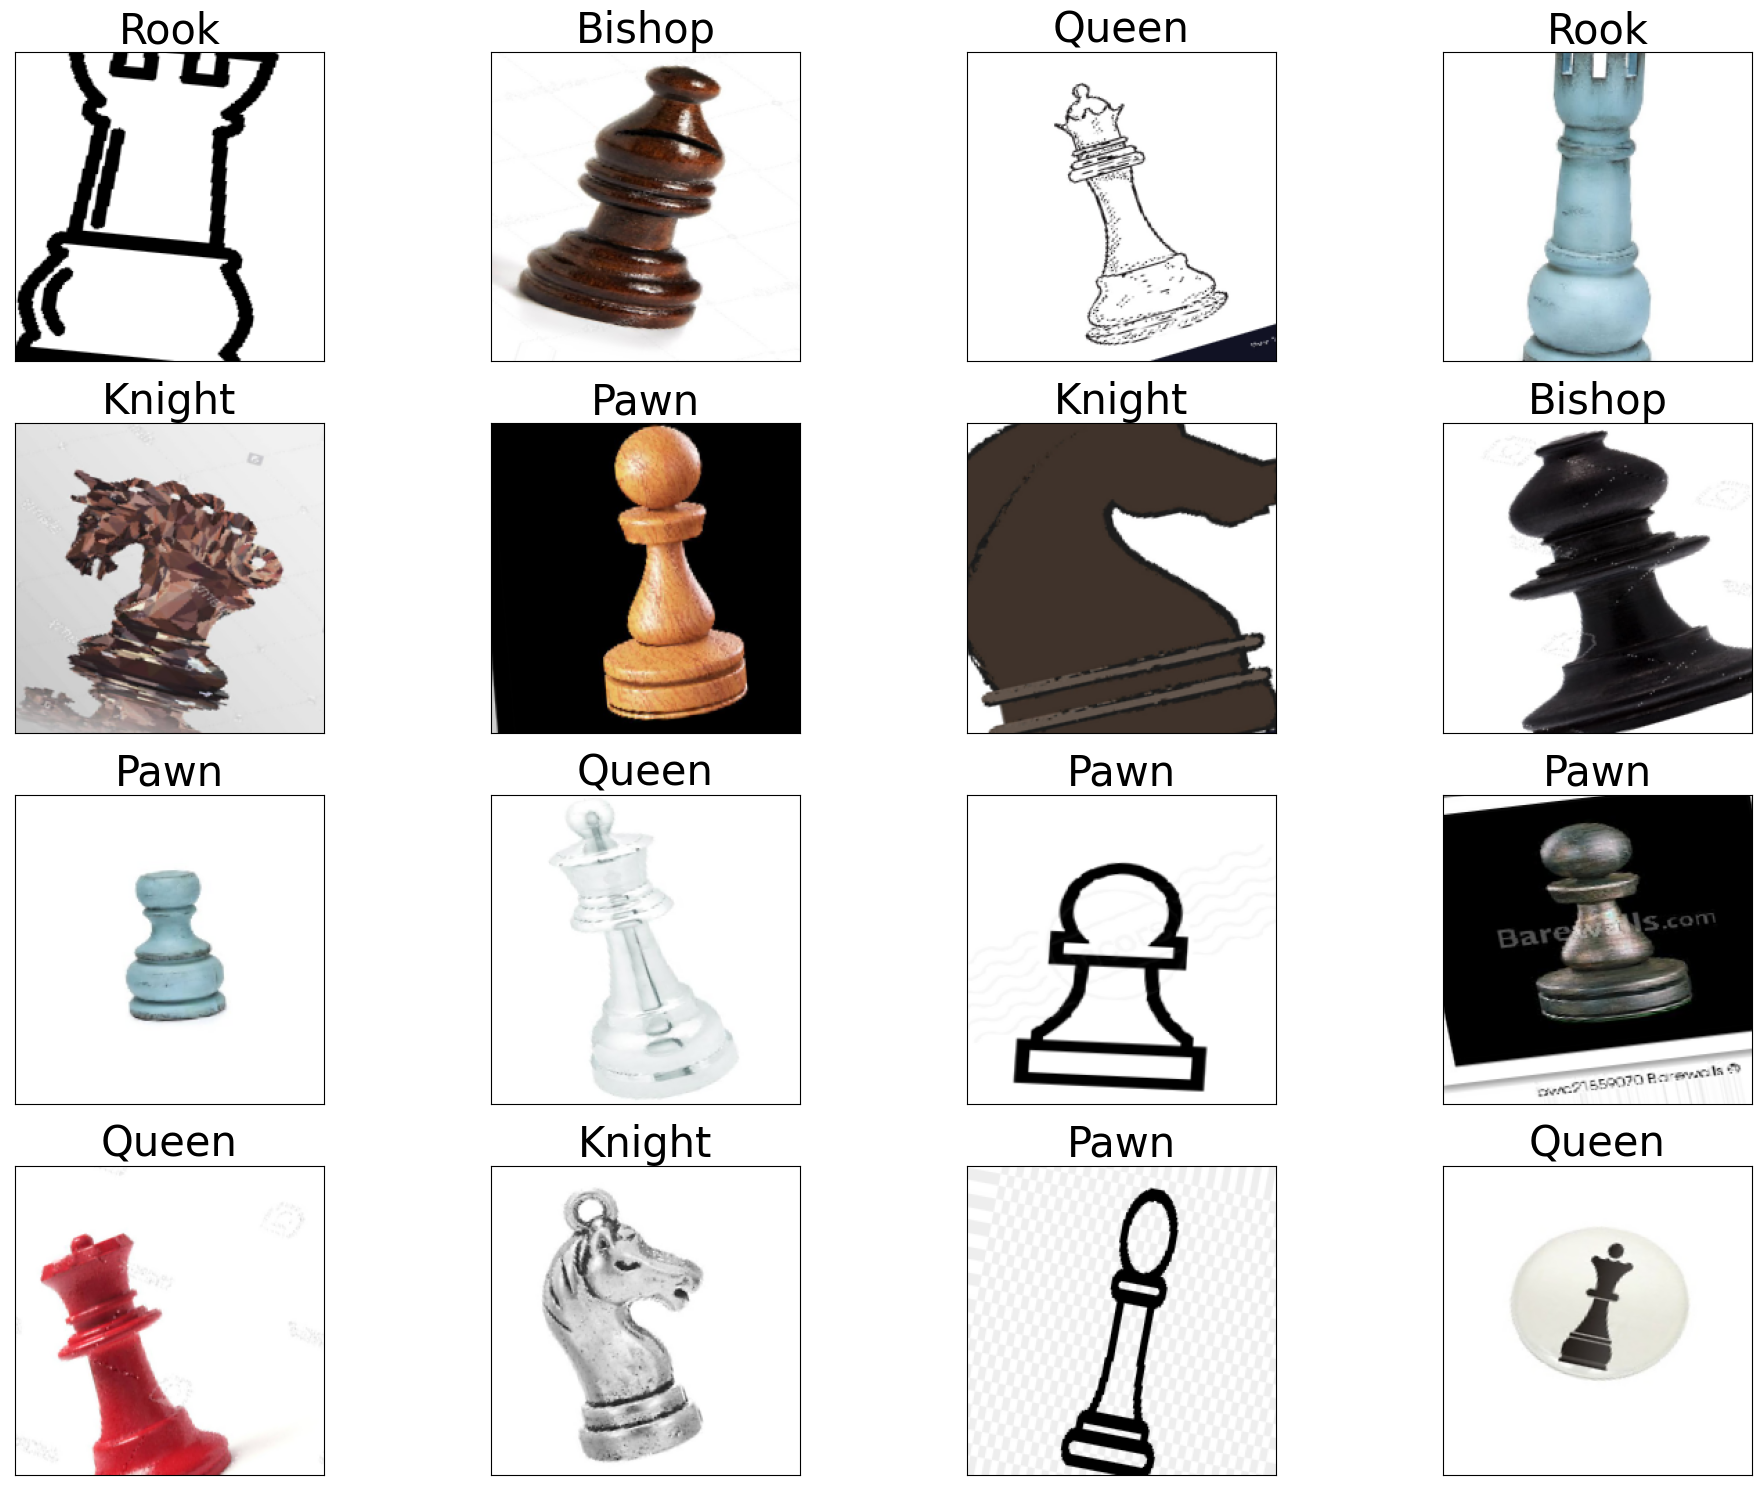

In [14]:
# 데이터 증강 시각화

pred2label={}
for x in train_generator.class_indices.keys():
    pred2label[train_generator.class_indices[x]] = x


plt.figure(figsize=(20,15))
index = np.random.randint(len(train_df), size=batch_size)
x_augs, y_augs = train_generator.next()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_augs[i, :, :, :])
    plt.title(pred2label[np.argmax(y_augs[i, :])], fontsize=30)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.tight_layout()
plt.show()

In [39]:
base_model = tf.keras.applications.VGG19(include_top = False) # Load the VGG19 model without the top layer
base_model.trainable = False # Freeze the base model layers to prevent backpropagation through them

inputs = tf.keras.Input(shape = (224, 224, 3)) # Input layer

x = base_model(inputs) # Pass the image through the base model
x = layers.Dropout(0.4)(x) # Apply dropout to prevent overfitting

x = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
x = layers.Dropout(0.5)(x)

x = tf.keras.layers.GlobalMaxPooling2D()(x) # Perform global max pooling to reduce the spatial dimensions
x = layers.Dropout(0.6)(x)

x = layers.Dense(6)(x) # Output layer 
outputs = layers.Activation("softmax")(x) 

# Create the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [40]:
print(height,  ' ', width, ' ', channel)

224   224   3


In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 256)         1179904   
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 256)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 256)              0         
 lMaxPooling2D)                                                  
                                                             

In [44]:
# 모델 컴파일 진행 - 아까와 달리 categorical_crossentropy 사용 > label이 숫자형 데이터이므로
model.compile(optimizer = Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])


# 조기멈춤
stop = EarlyStopping(patience=5)

# 자동 저장
checkpoint = ModelCheckpoint("./best_model",monitor='val_accuracy',
                            save_weights_only=True, mode='max',verbose=1,save_best_only=True)
callbacks = [stop, checkpoint]

# 모델 fitting
save = model.fit(train_generator,epochs = 20, validation_data=valid_generator, batch_size=32, callbacks=callbacks)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 5.5913 - accuracy: 0.1744
Epoch 00001: val_accuracy improved from -inf to 0.48387, saving model to .\best_model
23/23 [==============================] - 11s 373ms/step - loss: 5.5913 - accuracy: 0.1744 - val_loss: 1.7014 - val_accuracy: 0.4839
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 2.4300 - accuracy: 0.3025
Epoch 00002: val_accuracy improved from 0.48387 to 0.50806, saving model to .\best_model
23/23 [==============================] - 6s 253ms/step - loss: 2.4300 - accuracy: 0.3025 - val_loss: 1.4568 - val_accuracy: 0.5081
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.5006 - accuracy: 0.4441
Epoch 00003: val_accuracy improved from 0.50806 to 0.70161, saving model to .\best_model
23/23 [==============================] - 6s 257ms/step - loss: 1.5006 - accuracy: 0.4441 - val_loss: 1.2645 - val_accuracy: 0.7016
Epoch 4/20
23/23 [==============================] - ETA: 0s 

In [45]:
test_df = pd.read_csv(base_path + "/test.csv")
test_df.head(5)

,image,label
0,test_0.jpg,NaN
1,test_1.jpg,NaN
2,test_2.jpg,NaN
3,test_3.jpg,NaN
4,test_4.jpg,NaN


In [46]:
batch_size = len(test_df["image"])
height, width, channel = 224, 224, 3

In [47]:
# 테스트 이미지를 메모리에 올림.
test_path = base_path + '/test'

test_image = np.zeros((batch_size, height, width, channel))
print(test_image.shape)
cnt=0
for i in range(len(test_df["image"])):
    path_img = test_df['image'][i]
    img = image.load_img(os.path.join(test_path,path_img), target_size=(height, width))
    img_tensor = image.img_to_array(img)
    img_tensor = np.array(img_tensor,dtype="float32")

    img_tensor /= 255
    
    img_tensor = np.expand_dims(img_tensor, axis=0)
    
    test_image[i] = img_tensor

(60, 224, 224, 3)


In [49]:
predictions = model.predict(test_image)
predictions.shape

(60, 6)

In [50]:
test_df['label'] = [pred2label[np.argmax(pred)] for pred in predictions]
test_df

,image,label
0,test_0.jpg,Bishop
1,test_1.jpg,Knight
2,test_2.jpg,Bishop
3,test_3.jpg,Bishop
4,test_4.jpg,Pawn
5,test_5.jpg,King
6,test_6.jpg,Bishop
7,test_7.jpg,Bishop
8,test_8.jpg,Pawn
9,test_9.jpg,Bishop


In [51]:
test_df.to_csv('./submission.csv', index=False)